## Import Library

In [1]:
import re
import nltk
import string
import codecs
import warnings
import numpy as np
import pandas as pd
import fasttext.util
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers, models, initializers, regularizers, constraints, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Embedding, Dropout, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization, Bidirectional, LSTM, GlobalMaxPooling1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence

from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

warnings.simplefilter(action="ignore", category=FutureWarning)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Preparation

Menyiapkan fungsi-fungsi yang dibutuhkan untuk melakukan pemrosesan seperti pembangkit index embedding, matriks embedding, hingga preprocessing teks. 

In [2]:
lemmatizer = WordNetLemmatizer()

def fasttext_embedding():
    
    dictionary = {}
    file = codecs.open('../input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec', encoding='utf-8')
    for line in tqdm(file, desc="Load Vector Model "):
        values = line.rstrip().rsplit(' ')
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        dictionary[word] = coefs
    file.close()
    return dictionary

def embedding_matrix(tokenizer, embeddings_index, size):
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, size))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def longest_sentence(sentences):
    max = 0
    idx = 0
    for i in range(len(sentences)):
        words = sentences[i].split(' ')
        if(len(words) > max):
            max = len(words)
            idx = i
    return max, idx

def label_encoding(label):
    if(label == 'fact-based'):
        return 0
    elif(label == 'feeling-based'):
        return 1
    else:
        return 2
    
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def sentence_pos_tag(sentence):
    text = word_tokenize(sentence)
    pos_tag = nltk.pos_tag(text)
    pos_tag_res = ''
    for i in range(len(pos_tag)):
        pos_tag_res += pos_tag[i][1]
        pos_tag_res += ' ' if i != len(sentence)-1 else '' 
    return pos_tag_res

def preprocessing(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r" \d+ ", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"[^a-z ]", "", text)
    text = re.sub(r"  ", " ", text)
    text = lemmatize_sentence(text)
    return text

### Load Dataset

Dataset menggunakan hasil object python yang sudah diproses agar lebih cepat dan mudah dalam melakukan run berkali kali untuk keperluan eksperimen.

In [3]:
import pickle

file = open("../input/quote-response/quotexresponseprocessed.pkl", "rb")
df = pickle.load(file)
file.close()

In [4]:
df = df[df['emotion_fact'] != 'unsure']
df = df.loc[:, ['presented_quote', 'presented_response', 'emotion_fact', 'presented_response_tag']]
df

,presented_quote,presented_response,emotion_fact,presented_response_tag
0,i get a good idea however they do tend to stay...,by your own admission you havent hang out with...,feeling-based,IN PRP$ JJ NN PRP VBP VB RP IN NN IN DT NN CC ...
2,one of the big argument against gun control be...,not quite to be more correct regard government...,fact-based,RB RB TO VB RBR JJ JJ NN CC VB DT NN TO VB NN ...
4,there be some incedents that be beyond your co...,well yes,feeling-based,RB RB
6,legality do not matter religous implication do...,exact to the point amp beautiful,feeling-based,NN TO DT NN NN NN
8,once again you seem to support the killing of ...,base on the idea that people be dispensible pa...,feeling-based,NN IN DT NN WDT NNS VB JJ RB IN PRP VBP PRP$ V...
...,...,...,...,...
9977,the id movement form of id state that there be...,that of course be the logical fallacy know as ...,fact-based,DT IN NN VB DT JJ NN VBP IN JJ NN DT NN PRP VB...
9978,for me it would therefore have make no differe...,it logically follow from the moral foundation ...,feeling-based,PRP RB VBP IN DT JJ NN VBN RP CC PRP VBP TO JJ...
9979,good thing this argument have never be doneoh ...,and teen sex doesnt by the very nature of its ...,feeling-based,CC JJ NN NN IN DT JJ NN IN PRP$ NN NN IN NN DT...
9980,i know one thing anything that happen politica...,wasnt sinjin crow about his plan to take the f...,feeling-based,NN NN NN IN PRP$ NN TO VB DT NN NN CC NN TO DT...


In [5]:
# df['presented_quote'] = df['presented_quote'].apply(lambda x: preprocessing(x))
# df['presented_response'] = df['presented_response'].apply(lambda x: preprocessing(x))
df['emotion_fact'] = df['emotion_fact'].apply(lambda x: label_encoding(x))

In [6]:
from sklearn.model_selection import train_test_split

X = df.loc[:, ['presented_quote', 'presented_response', 'presented_response_tag']]
y = df.loc[:, ['emotion_fact']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)

In [7]:
X_train_quotes = X_train['presented_response'].values
X_train_responses = X_train['presented_response'].values
X_train_responses_tag = X_train['presented_response_tag'].values

X_test_quotes = X_test['presented_response'].values
X_test_responses = X_test['presented_response'].values
X_test_responses_tag = X_test['presented_response_tag'].values

y_train = y_train['emotion_fact'].values
y_test = y_test['emotion_fact'].values

X_train_text = X_train_quotes + X_train_responses

In [8]:
tokenizer = Tokenizer(num_words=300000)
tokenizer.fit_on_texts(list(X_train_text))

X_train_quotes = tokenizer.texts_to_sequences(X_train_quotes)
X_train_responses = tokenizer.texts_to_sequences(X_train_responses)
X_train_responses_tag = tokenizer.texts_to_sequences(X_train_responses_tag)

X_test_quotes = tokenizer.texts_to_sequences(X_test_quotes)
X_test_responses = tokenizer.texts_to_sequences(X_test_responses)
X_test_responses_tag = tokenizer.texts_to_sequences(X_test_responses_tag)

X_train_quotes = sequence.pad_sequences(X_train_quotes, maxlen=1000)
X_train_responses = sequence.pad_sequences(X_train_responses, maxlen=1000)
X_train_responses_tag = sequence.pad_sequences(X_train_responses_tag, maxlen=1000)

X_test_quotes = sequence.pad_sequences(X_test_quotes, maxlen=1000)
X_test_responses = sequence.pad_sequences(X_test_responses, maxlen=1000)
X_test_responses_tag = sequence.pad_sequences(X_test_responses_tag, maxlen=1000)


In [9]:
print(X_train_quotes.shape)
print(X_train_responses.shape)
print(X_test_quotes.shape)
print(X_test_responses.shape)

(4972, 1000)
(4972, 1000)
(878, 1000)
(878, 1000)


In [10]:
fasttext_index = fasttext_embedding()
fasttext_matrix = embedding_matrix(tokenizer, fasttext_index, 300)

Load Vector Model : 1999996it [05:10, 6436.12it/s]


## Model 1 (Input Quote dan Response dalam Arsitektur BiLSTM sederhana)

In [11]:
quote_input    = keras.Input(shape=(None,), name='quote')
response_input = keras.Input(shape=(None,), name='response')

quote_feature    = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(quote_input)
response_feature = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(response_input)

quote_feature    = layers.Bidirectional(LSTM(100, return_sequences=True))(quote_feature)
quote_feature    = layers.LSTM(100, return_sequences=False)(quote_feature)

response_feature = layers.Bidirectional(LSTM(100, return_sequences=True))(response_feature)
response_feature = layers.LSTM(25, return_sequences=False)(response_feature)

double = layers.concatenate([quote_feature, response_feature])

dense  = layers.Dense(200, activation='relu')(double)

dense  = layers.Dropout(0.3)(dense)  

pred   = layers.Dense(2, activation='softmax', name='argument_emotion')(dense)

model = keras.Model(inputs=[quote_input, response_input], outputs=[pred],)

2021-11-16 16:30:39.158499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 16:30:39.269041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 16:30:39.269851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 16:30:39.271096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
quote (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
response (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7404600     quote[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    7404600     response[0][0]                   
______________________________________________________________________________________________

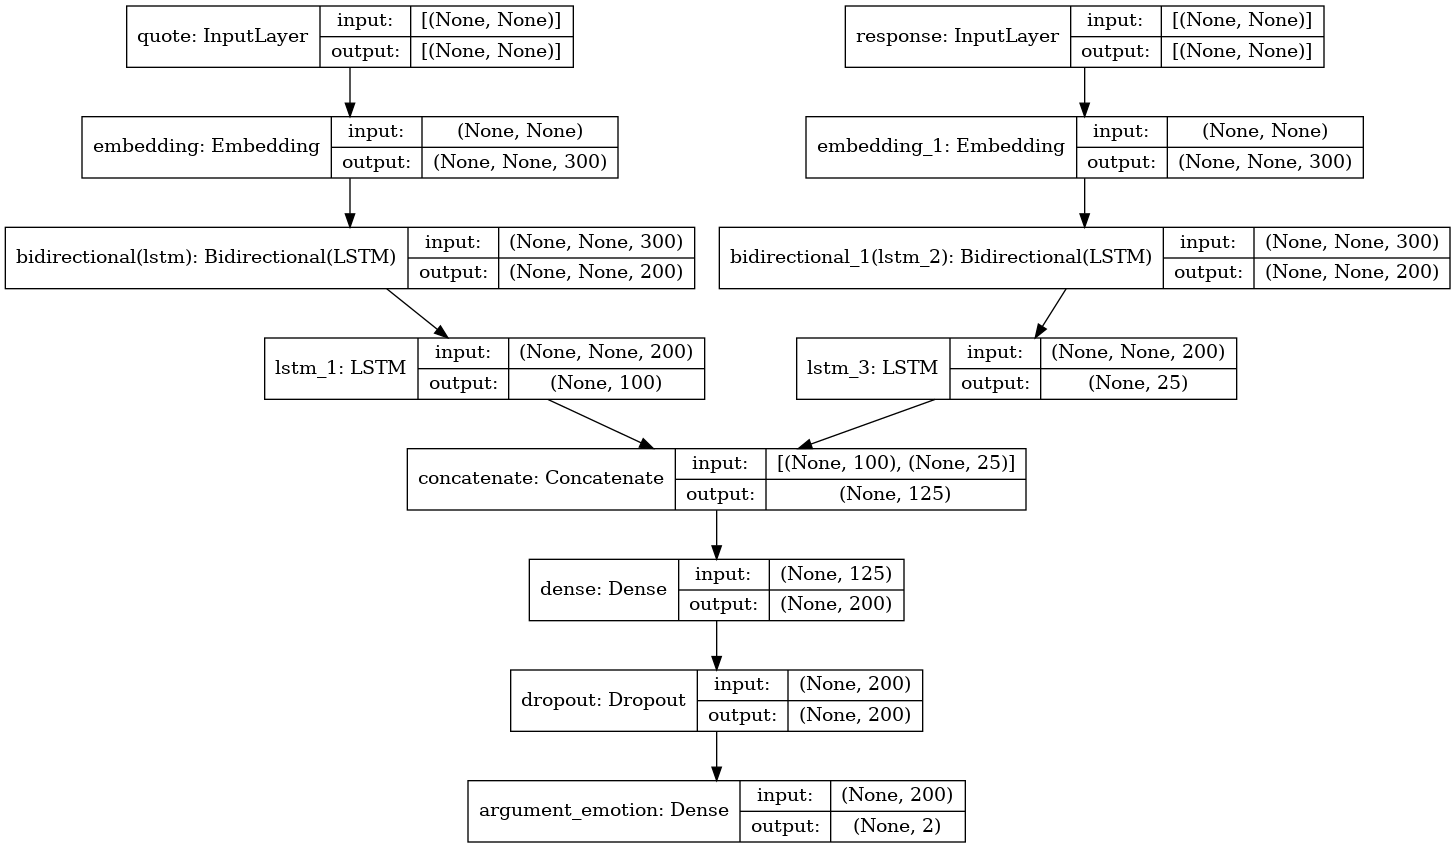

In [13]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [14]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    {'quote': X_train_quotes, 'response': X_train_responses},
    {'argument_emotion': y_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

2021-11-16 16:30:48.798630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-16 16:30:57.200888: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


140/140 [==============================] - 48s 275ms/step - loss: 0.5584 - accuracy: 0.7047 - val_loss: 0.5138 - val_accuracy: 0.7490
Epoch 2/10
140/140 [==============================] - 36s 259ms/step - loss: 0.4910 - accuracy: 0.7613 - val_loss: 0.5385 - val_accuracy: 0.7088
Epoch 3/10
140/140 [==============================] - 36s 259ms/step - loss: 0.4882 - accuracy: 0.7684 - val_loss: 0.5055 - val_accuracy: 0.7410
Epoch 4/10
140/140 [==============================] - 37s 262ms/step - loss: 0.4524 - accuracy: 0.7955 - val_loss: 0.5197 - val_accuracy: 0.7349
Epoch 5/10
140/140 [==============================] - 37s 261ms/step - loss: 0.4743 - accuracy: 0.7702 - val_loss: 0.6072 - val_accuracy: 0.6727
Epoch 6/10
140/140 [==============================] - 37s 265ms/step - loss: 0.5222 - accuracy: 0.7452 - val_loss: 0.5330 - val_accuracy: 0.7108
Epoch 7/10
140/140 [==============================] - 37s 266ms/step - loss: 0.4661 - accuracy: 0.7785 - val_loss: 0.5333 - val_accuracy: 0.7

In [15]:
prediction = model.predict({'quote': X_test_quotes, 'response': X_test_responses})

In [16]:
prediction

array([[0.9349352 , 0.06506484],
       [0.32258895, 0.677411  ],
       [0.9873417 , 0.01265834],
       ...,
       [0.9493246 , 0.05067546],
       [0.8333236 , 0.16667636],
       [0.6832249 , 0.3167751 ]], dtype=float32)

In [17]:
re = []
for predict in prediction:
    label = np.argmax(predict)
    re.append(label)
    
re = np.array(re)

re

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, re))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       524
           1       0.75      0.57      0.65       354

    accuracy                           0.75       878
   macro avg       0.75      0.72      0.73       878
weighted avg       0.75      0.75      0.75       878



In [19]:
model.save('model_fasttext_1')

2021-11-16 16:37:50.427133: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Model 2 (Input Response dan Response POS TAG dalam Arsitektur BiLSTM sederhana)

In [20]:
quote_input    = keras.Input(shape=(None,), name='response')
response_input = keras.Input(shape=(None,), name='response_tag')

quote_feature    = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(quote_input)
response_feature = layers.Embedding(fasttext_matrix.shape[0], input_length=1000, output_dim=fasttext_matrix.shape[1], weights=[fasttext_matrix], trainable=False)(response_input)

quote_feature    = layers.Bidirectional(LSTM(100, return_sequences=True))(quote_feature)
quote_feature    = layers.LSTM(100, return_sequences=False)(quote_feature)

response_feature = layers.Bidirectional(LSTM(100, return_sequences=True))(response_feature)
response_feature = layers.LSTM(25, return_sequences=False)(response_feature)

double = layers.concatenate([quote_feature, response_feature])

dense  = layers.Dense(200, activation='relu')(double)

dense  = layers.Dropout(0.3)(dense)  

pred   = layers.Dense(2, activation='softmax', name='argument_emotion')(dense)

model2 = keras.Model(inputs=[quote_input, response_input], outputs=[pred],)

In [21]:
model2.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model2.fit(
    {'response': X_train_responses, 'response_tag': X_train_responses_tag},
    {'argument_emotion': y_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
140/140 [==============================] - 44s 266ms/step - loss: 0.5605 - accuracy: 0.7068 - val_loss: 0.5312 - val_accuracy: 0.7349
Epoch 2/10
140/140 [==============================] - 36s 256ms/step - loss: 0.4794 - accuracy: 0.7798 - val_loss: 0.5483 - val_accuracy: 0.7430
Epoch 3/10
140/140 [==============================] - 36s 261ms/step - loss: 0.4567 - accuracy: 0.7928 - val_loss: 0.5258 - val_accuracy: 0.7470
Epoch 4/10
140/140 [==============================] - 36s 260ms/step - loss: 0.4465 - accuracy: 0.7919 - val_loss: 0.5867 - val_accuracy: 0.7229
Epoch 5/10
140/140 [==============================] - 36s 260ms/step - loss: 0.4017 - accuracy: 0.8219 - val_loss: 0.5542 - val_accuracy: 0.7369
Epoch 6/10
140/140 [==============================] - 37s 262ms/step - loss: 0.4274 - accuracy: 0.7973 - val_loss: 0.6013 - val_accuracy: 0.7249
Epoch 7/10
140/140 [==============================] - 37s 262ms/step - loss: 0.3669 - accuracy: 0.8319 - val_loss: 0.5747 - val_ac

In [22]:
prediction = model2.predict({'response': X_test_responses, 'response_tag': X_test_responses_tag})

In [23]:
re = []
for predict in prediction:
    label = np.argmax(predict)
    re.append(label)
    
re = np.array(re)

re

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, re))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       524
           1       0.67      0.69      0.68       354

    accuracy                           0.73       878
   macro avg       0.72      0.73      0.73       878
weighted avg       0.74      0.73      0.74       878

